## Segmenting a single cell from a volume image

In order to remap a cell surface in u-Unwrap3D, the cell must be first segmented from the volumetric image and a surface mesh created. This workbook walks through this process. 

### Binary segmentation with Otsu thresholding

We read in the volume image used in Fig.1 of the paper and also create a savefolder to store the results of analysis.

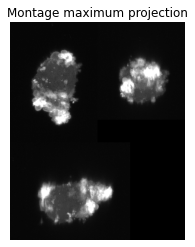

In [8]:
import skimage.io as skio 
import os 
import numpy as np 
import pylab as plt 

import unwrap3D.Visualisation.volume_img as vol_img_viz # for creating a montage maximum projection
import unwrap3D.Utility_Functions.file_io as fio # for common IO functions

imgfolder = 'example_data/img'
imgfile = os.path.join(imgfolder, 'bleb_example.tif')

basefname = os.path.split(imgfile)[-1].split('.tif')[0] # get the filename with extension

"""
Initialise a save folder to store the important outputs for the result of the pipeline.
"""
savefolder = os.path.join('example_results', 
                         basefname,
                         'step0_cell_segmentation')
fio.mkdir(savefolder) # auto generates the specified folder structure if doesn't currently exist.


"""
Read and display image
"""
# read the image using scikit-image
img = skio.imread(imgfile)

# utility function in u-Unwrap3D to generate a montage maximum projection of the 3 orthogonal views for display
img_proj = vol_img_viz.montage_vol_proj(img, np.max)


plt.figure()
plt.title('Montage maximum projection')
plt.imshow(img_proj, cmap='gray')
plt.grid('off')
plt.axis('off')
plt.savefig(os.path.join(savefolder,
                        basefname+'_max-proj_three.png'), dpi=300, bbox_inches='tight')
plt.show()


Since the signal-to-noise ratio of this is good, we segment with an intensity threshold automatically determined from Otsu's method from the scikit-image library.

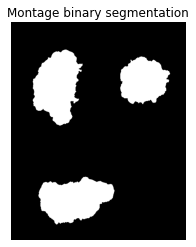

In [9]:
import unwrap3D.Segmentation.segmentation as segmentation # import the segmentation submodule which wraps the Otsu method
import scipy.ndimage as ndimage # use instead of scikit-image for faster morphological operations in 3D
import skimage.morphology as skmorph

# returns the binary and the auto determined threshold. 
img_binary, img_binary_thresh = segmentation.segment_vol_thresh(img)
# erode by ball kernel radius = 1 to make a tighter binary
img_binary = ndimage.binary_erosion(img_binary, 
                                    iterations=1, 
                                    structure=skmorph.ball(1))
img_binary_proj = vol_img_viz.montage_vol_proj(img_binary, np.max)

plt.figure()
plt.title('Montage binary segmentation')
plt.imshow(img_binary_proj, cmap='gray')
plt.grid('off')
plt.axis('off')
plt.savefig(os.path.join(savefolder,
                         basefname+'_binary_three.png'), dpi=300, bbox_inches='tight')
plt.show()

"""
Save the binary out as a uint8 .tif
"""
skio.imsave(os.path.join(savefolder,
                         basefname+'_binary_seg.tif'), 
            np.uint8(255*img_binary))


### Mean curvature measurement from binary segmentation

Measuring mean curvature from a mesh involves fitting a local plane to neighborhood vertices. As such the result is subject to the quality of the triangle faces and choice of neighborhood radius. We find it easier and more accurate for downstream quantification to apply the continuous definition of mean curvature, $H$

$$ H = {-\frac{1}{2} \nabla \cdot \hat{n}} $$

where $\hat{n}$ is the unit surface normal vector, and also the gradient of the signed distance function $\Phi$ of the binary segmentation.

$$ \hat{n} = {\nabla \Phi} $$

C:\Users\fyz11\anaconda3\envs\unwrap3D\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: Mean of empty slice
  
C:\Users\fyz11\anaconda3\envs\unwrap3D\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: Mean of empty slice
  # Remove the CWD from sys.path while we load stuff.
C:\Users\fyz11\anaconda3\envs\unwrap3D\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: Mean of empty slice
  if sys.path[0] == "":


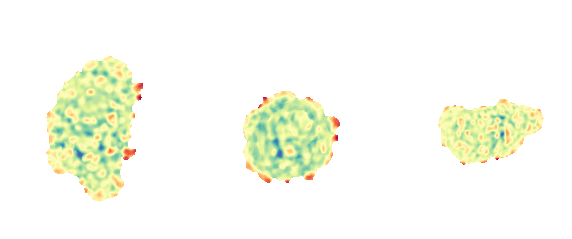

In [10]:
# compute the continuous mean curvature definition and smooth slightly with a Gaussian of sigma=3.  
H_binary, H_sdf_vol_normal, H_sdf_vol = segmentation.mean_curvature_binary(img_binary, 
                                                                           smooth=3, 
                                                                           mask=True) # if mask=True, only the curvature of a thin shell (+/-smooth) around the binary segmentation is returned. 

plt.figure(figsize=(10,10))
plt.subplot(131)
plt.imshow(np.nanmean(H_binary,axis=0), cmap='Spectral_r'); plt.grid('off'); plt.axis('off')
plt.subplot(132)
plt.imshow(np.nanmean(H_binary,axis=1), cmap='Spectral_r'); plt.grid('off'); plt.axis('off')
plt.subplot(133)
plt.imshow(np.nanmean(H_binary,axis=2), cmap='Spectral_r'); plt.grid('off'); plt.axis('off')
plt.show()


# if mask=True above, the following line is necessary to enable interpolation.
H_binary[np.isnan(H_binary)] = 0 

### Surface meshing the binary segmentation and mapping the curvature onto the mesh

We mesh the binary segmentation with Marching Cubes at an isovalue of 0.5 and also apply remeshing to obtain regular equilateral triangle faces. We color the surface according to the mean curvature calculated above.

In [11]:
import unwrap3D.Mesh.meshtools as meshtools # load in the meshtools submodule
import unwrap3D.Image_Functions.image as image_fn # for common image processing functions
import unwrap3D.Visualisation.colors as vol_colors # this is for colormapping any np.array using a color palette 
from matplotlib import cm # this is for specifying a matplotlib color palette

img_binary_surf_mesh = meshtools.marching_cubes_mesh_binary(img_binary.transpose(2,1,0), # The transpose is to be consistent with ImageJ rendering and Matlab convention  
                                                                presmooth=1., # applies a presmooth
                                                                contourlevel=.5,
                                                                remesh=True,
                                                                remesh_method='pyacvd', 
                                                                remesh_samples=.9, # remeshing with a target #vertices = 90% of original
                                                                predecimate=True, # this applies quadric mesh simplication to remove very small edges before remeshing
                                                                min_mesh_size=60000,
                                                                upsamplemethod='loop') # upsample the mesh if after the simplification and remeshing < min_mesh_size  
"""
A quick way to check the genus is to get the euler number. The genus of the mesh is related to the euler number by
A genus-0 mesh should have euler number = 2
"""
print('Euler characteristic of mesh is: ', img_binary_surf_mesh.euler_number) #should be 2 if genus is 0

# we also provide a more comprehensive function for common mesh properties
mesh_property = meshtools.measure_props_trimesh(img_binary_surf_mesh, main_component=True, clean=True) 

print(mesh_property)


"""
We interpolate the mean curvature at the mesh vertex points using trilinear interpolation and convert this to a colormap to 'paint' onto the mesh
"""
# interpolation 
surf_H = image_fn.map_intensity_interp3(img_binary_surf_mesh.vertices[:,::-1], # undo the transpose to be consistent with the volume
                                            grid_shape= H_binary.shape, 
                                            I_ref= H_binary, 
                                            method='linear', 
                                            cast_uint8=False)

# we generate colors from the mean curvature 
surf_H_colors = vol_colors.get_colors(surf_H/.104, # 0.104 is the voxel resolution -> this converts to um^-1 
                                      colormap=cm.Spectral_r, 
                                      vmin=-1., 
                                      vmax=1.) # colormap H with lower and upper limit of -1, 1 um^-1. 

# set the vertex colors to the computed mean curvature color
img_binary_surf_mesh.visual.vertex_colors = np.uint8(255*surf_H_colors[...,:3]) 

# save the mesh for viewing in an external program such as meshlab which offers much better rendering capabilities
tmp = img_binary_surf_mesh.export(os.path.join(savefolder, 'curvature_binary_mesh_'+basefname+'.obj')) # tmp is used to prevent printing to screen.


Euler characteristic of mesh is:  2
{'convex': False, 'volume': True, 'watertight': True, 'orientability': True, 'euler_number': 2, 'genus': 0.0}


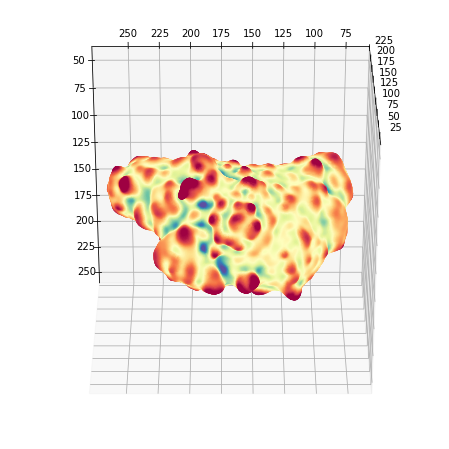

In [12]:
# the mesh is best viewed in a dedicated mesh viewer such as meshlab which is opensource, free and cross-platform. We can get an idea by plotting and coloring the mesh vertices using matplotlib

import unwrap3D.Visualisation.plotting as plotting # we import this so we can make x,y,z axes be plotted in equal proportions. 

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(projection='3d')
ax.scatter(img_binary_surf_mesh.vertices[...,2], 
           img_binary_surf_mesh.vertices[...,1],
           img_binary_surf_mesh.vertices[...,0], 
           s=1, 
           c=surf_H/.104, 
           cmap='Spectral_r', 
           vmin=-1,
           vmax=1)
ax.view_init(-60, 180)
plotting.set_axes_equal(ax)
plt.show()

### Mapping surface proximal membrane signals by traversing along the steepest gradient descent normal into the cell

We can use active contour conformalized mean curvature flow to traverse into the cell and sample the image intensity at designed step sizes $\alpha$. We can then average the sampled intensity and map this onto the cell surface. We do this for our cell up to 1um depth. Our image has an isotropic voxel resolution of 0.104um. We sample this depth in steps of 0.5 voxels. This equates to a total of 2/0.104 steps rounded down to the nearest integer. 

This sampling procedure is more precise than performing spherical nearest neighbor lookup which oversmooths the signal. 

In [13]:
n_samples = 1./ .104 # total number of steps
stepsize = 0.5 # voxels
    
# flip the mesh vertex coordinates so that it aligns with the volume size 
img_binary_surf_mesh.vertices = img_binary_surf_mesh.vertices[:,::-1].copy()

# run the active contour cMCF to get the coordinates at different depths into the cell according to the external image gradient given by the gradient of the signed distance function.
v_depth = meshtools.parametric_mesh_constant_img_flow(img_binary_surf_mesh, 
                                                      external_img_gradient = H_sdf_vol_normal.transpose(1,2,3,0), 
                                                      niters=int(n_samples/stepsize), 
                                                      deltaL=5e-5, # delta which controls the stiffness of the mesh
                                                      step_size=stepsize, 
                                                      method='implicit', # this specifies the cMCF solver.
                                                      conformalize=True) # ensure we use the cMCF Laplacian

# we can check the size of the array
print(v_depth.shape)

# we can plot the trajectory with matplotlib 

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [03:24<00:00, 10.78s/it]

(159334, 3, 20)


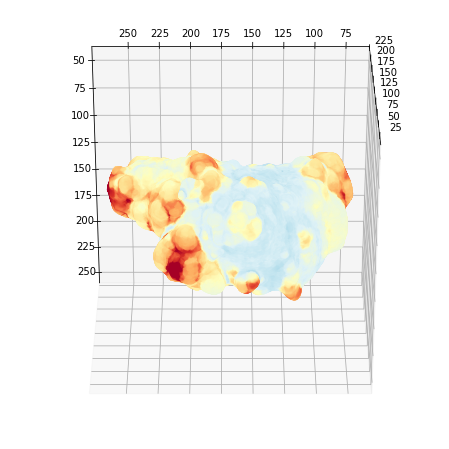

In [14]:
# get the intensities at the sampled depth coordinates. 
v_depth_I = image_fn.map_intensity_interp3(v_depth.transpose(0,2,1).reshape(-1,3), 
                                            img.shape, 
                                            I_ref=img)
v_depth_I = v_depth_I.reshape(-1,v_depth.shape[-1]) # matrix reshaping into a nicer shape. 

# postprocess to check the total distance from the surface does not exceed the desired and replace any nans.  
dist_v_depth0 = np.linalg.norm(v_depth - v_depth[...,0][...,None], axis=1)
valid_I = dist_v_depth0<=n_samples
v_depth_I[valid_I == 0 ] = np.nan # replace with nans


# compute the mean sampled intensity which will be taken as the surface intensity. 
surf_intensity_img_raw = np.nanmean(v_depth_I, axis=1)
surf_intensity_img_raw[np.isnan(surf_intensity_img_raw)] = 0

# for visualization, we find the intensity range to be more pleasing if clipped to between the 1st and 99th percentile. 
I_min = np.percentile(surf_intensity_img_raw,1)
I_max = np.percentile(surf_intensity_img_raw,99)

surf_intensity_img_raw_colors = vol_colors.get_colors(surf_intensity_img_raw, 
                                                      colormap=cm.RdYlBu_r,   
                                                      vmin=I_min, 
                                                      vmax=I_max)
# create a new surface mesh, now with the PI3K molecular signal colors. 
img_binary_surf_mesh_colors = meshtools.create_mesh(vertices=img_binary_surf_mesh.vertices[:,::-1],
                                                  faces=img_binary_surf_mesh.faces, 
                                                  vertex_colors=np.uint8(255*surf_intensity_img_raw_colors[...,:3])) 
tmp = img_binary_surf_mesh_colors.export(os.path.join(savefolder, 
                                                'PI3K_binary_mesh_'+basefname+'.obj')) # tmp is used to prevent printing to screen.


# again we can quickly view the coloring in matplotlib
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(projection='3d')
ax.scatter(img_binary_surf_mesh_colors.vertices[...,2], 
           img_binary_surf_mesh_colors.vertices[...,1],
           img_binary_surf_mesh_colors.vertices[...,0], 
           s=1, 
           c=surf_intensity_img_raw, 
           cmap='RdYlBu_r', 
           vmin=-I_min,
           vmax=I_max)
ax.view_init(-60, 180)
plotting.set_axes_equal(ax)
plt.show()


# finally we will save the actual numerical values of the surface curvature and intensity to avoid recomputation to use for other steps of the pipeline
import scipy.io as spio # we save in .mat, this will allow matlab users to use the output if desired
spio.savemat(os.path.join(savefolder, 
                          basefname+'_surface_curvature_intensity_stats.mat'), 
            {'surf_H': surf_H,
             'surf_intensity' : surf_intensity_img_raw})


## We now proceed to step 1 notebook to run conformalized mean curvature flow and derive a genus-0 reference shape ...